# Tropics Temperature Quantile Theory from Byrne 2021
This looks at applying the theory from Byrne 2021 to the simplified Isca simulations to see how well it performs.

In [57]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore

In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.2
exp_dir = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/'
exp_names = [f'k={tau_lw_ref}', f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]
max_bucket_depth_land = namelist['idealized_moist_phys_nml']['max_bucket_depth_land']

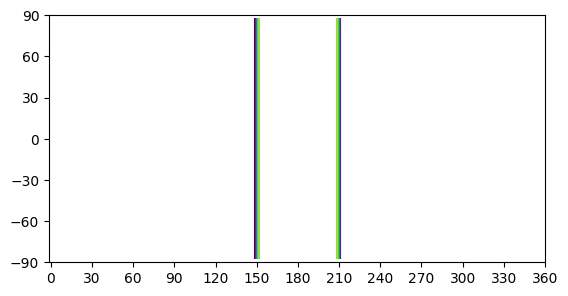

In [4]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get one dataset, `ds_quant`, for land, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the ocean summer for a given latitude bin.

In [5]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 30
# lat_max = 60

ds_all = {'land':[], 'ocean': []}
ds_summer = []
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in ['land', 'ocean']:
            ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
            ds_use = ds_use.sel(lon=np.unique(lon[surf]), method='nearest')
            ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
            ds_all[surf] += [ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))]
            ds_all[surf][i].load()
            # if surf == 'ocean':
            #     ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
            #     ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
            #     # Combine hemispheres and average over longitude, time and latitude.
            #     ds_use = xr.concat([ds_nh_summer, ds_sh_summer], dim='lat')
            #     ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
            #     ds_summer += [ds_use]
            #     ds_summer[i].load()
            pbar.update(1)

100%|██████████| 4/4 [00:33<00:00,  8.39s/it]


## MSE Percentile vs Temperature Percentile
Recreating Extended Data Figure 1 of Byrne 2021.

Want the MSE percentile corresponding to the average MSE of days exceeding a given temperature percentile

In [6]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp[-1].quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp[-1] > quantile_thresh)[0]
    return quant_ind

surfaces = ['ocean', 'land']
n_surf = len(surfaces)
quant_plot = np.arange(100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)

# surface values corresponding to the average obove a given percentile in temperature
temp_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
sphum_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
z_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
mse_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}


with tqdm(total=n_exp*n_quant*n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            for surf in surfaces:
                use_ind = get_quant_ind(ds_all[surf][i], quant)
                temp_quant[surf][i, j] = np.mean(ds_all[surf][i].temp[-1][use_ind])
                sphum_quant[surf][i, j] = np.mean(ds_all[surf][i].sphum[-1][use_ind])
                z_quant[surf][i, j] = np.mean(ds_all[surf][i].height[-1][use_ind])
                mse_quant[surf][i, j] = np.mean(moist_static_energy(ds_all[surf][i].temp[-1][use_ind],
                                                                    ds_all[surf][i].sphum[-1][use_ind],
                                                                    ds_all[surf][i].height[-1][use_ind]))
                pbar.update(1)

# temp_mean = {surf: np.asarray([temp_quant[surf][i][0] for i in range(n_exp)]) for surf in surfaces}

100%|██████████| 400/400 [00:31<00:00, 12.84it/s]


In [7]:
# Get MSE percentile, p_x, corresponding to MSE averaged over all days exceeding x percentile in temperature
mse_quant_px = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
with tqdm(total=n_exp*n_quant*n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in surfaces:
            mse_all = moist_static_energy(ds_all[surf][i].temp[-1], ds_all[surf][i].sphum[-1], ds_all[surf][i].height[-1])
            for j, quant in enumerate(quant_plot):
                mse_quant_px[surf][i, j] = percentileofscore(mse_all, mse_quant[surf][i, j])
                pbar.update(1)

100%|██████████| 400/400 [00:00<00:00, 507.75it/s]


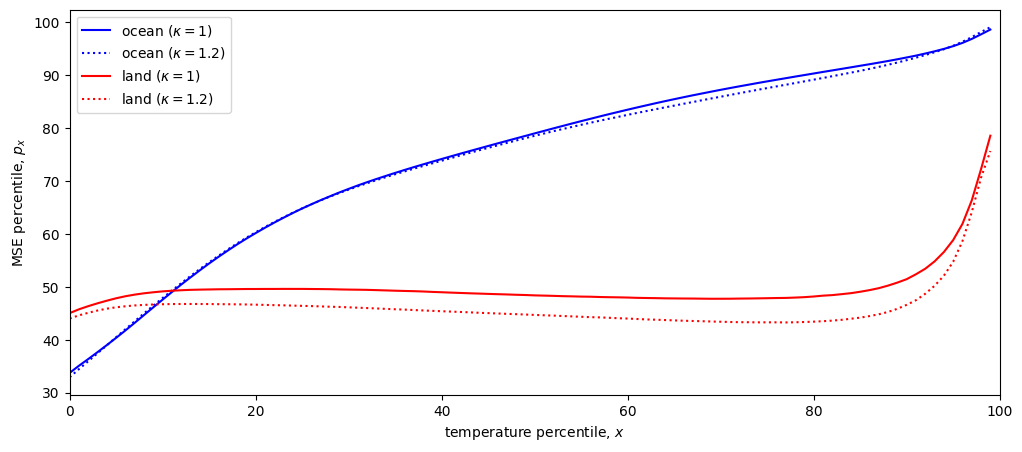

In [8]:
plt_color = {'land': 'red', 'ocean': 'blue'}
linestyles = ['-', ':']     # different for each kappa
fig, ax = plt.subplots(1,1, figsize=(12, 5), sharex=True)
for surf in surfaces:
    for i in range(n_exp):
        ax.plot(quant_plot, mse_quant_px[surf][i], color=plt_color[surf], linestyle=linestyles[i],
                label=f'{surf} ($\kappa={tau_lw[i]}$)')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE percentile, $p_x$')
ax.set_xlim(0,100);

The ocean plot shows good agreement with Byrne 2021, and this also shows that for the warmer simulation there is a decrease in $p_x$ as seen in Byrne 2021.

However, here we see an increase in $p_x$ for large $x$ but in byrne 2021, we see a decrease.

## Land to Ocean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3. It seems pretty close to the results shown in the paper, implying that the assumption of equal change in MSE percentiles over land and ocean: $\delta h_L(p) = \delta h_O(p)$ may also be valid.

In [9]:
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
# mse as function of mse quantile not temp quantile
mse_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}

for i in range(n_exp):
        for k, ds_use in enumerate([ds_all['ocean'], ds_all['land']]):
            temp_quant2[surfaces[k]][i] = ds_use[i].temp[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
            sphum_quant2[surfaces[k]][i] = ds_use[i].sphum[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
            mse = moist_static_energy(ds_use[i].temp[-1], ds_use[i].sphum[-1], ds_use[i].height[-1])
            mse_quant2[surfaces[k]][i] = mse.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)

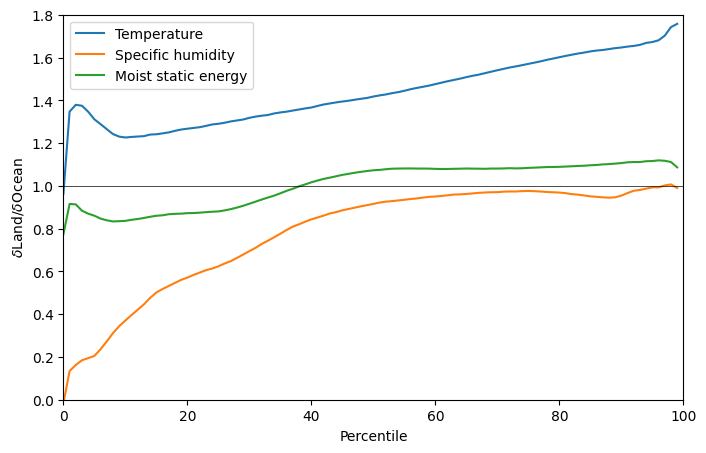

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
labels = ['Temperature', 'Specific humidity', 'Moist static energy']
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    ax.plot(quant_plot, (var['land'][1]-var['land'][0])/(var['ocean'][1]-var['ocean'][0]), label=labels[i])
ax.hlines(1,0,100, color='k', linewidth=0.5)
ax.legend()
ax.set_xlabel('Percentile')
ax.set_ylabel('$\delta$Land/$\delta$Ocean')
ax.set_ylim(0,1.8)
ax.set_xlim(0, 100);

## Theory for $\delta T_L^x$
The theory is based on the assumption of equal change in MSE percentiles over land and ocean: $\delta h_L(p) = \delta h_O(p)$. From the above plot, we see that this is most valid at the largest $x$.

This is reflected below, where the predicted temperature change is very close to the simulated for the largest $x$.

In [11]:
p_surface = float(ds_all['land'][0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

# Land constants required - all averaged over the x percentile temperature day
# i.e. there are 100 values for each of these constants
alpha_l = clausius_clapeyron_factor(temp_quant['land'][0])
q_l_x_sat = sphum_sat(temp_quant['land'][0], p_surface)
q_l_mean_sat = q_l_x_sat[0]
q_l_x = sphum_quant['land'][0]
r_l_x = q_l_x / q_l_x_sat
delta_r_l_x = sphum_quant['land'][1]/sphum_sat(temp_quant['land'][1], p_surface) - r_l_x
r_l_mean = r_l_x[0]
delta_r_l_mean = delta_r_l_x[0]

# Ocean constants required - these are for the percentile px which corresponds to the average above the x percentile in temperature
# We assumethe change in the p xth percentile of ocean moist static energy can be written to good approximation as
# a function of the individual changes in the pxth percentiles of temperature and specific humidity - from Methods page of paper
p_x = np.round(mse_quant_px['ocean'][0]).astype(int)        # p_x[i] is the percentile of MSE corresponding to average above the
                                                            # percentile quant_all[i] of temperature in reference climate.
temp_o = temp_quant2['ocean'][0][p_x]
delta_temp_o = temp_quant2['ocean'][1][p_x] - temp_o
q_o = sphum_quant2['ocean'][0][p_x]
q_o_sat = sphum_sat(temp_o, p_surface)
r_o = q_o / q_o_sat
delta_r_o = sphum_quant2['ocean'][1][p_x]/sphum_sat(temp_quant2['ocean'][1][p_x], p_surface) - r_o
alpha_o = clausius_clapeyron_factor(temp_o)

e_const = L_v * alpha_l * q_l_x_sat / (c_p + L_v * alpha_l * q_l_x)
nabla = q_l_mean_sat / q_l_x_sat * e_const / alpha_l
gamma_t = (c_p + L_v * alpha_o * q_o) / (c_p + L_v * alpha_l * q_l_x)
gamma_r_o = L_v * q_o_sat / (c_p + L_v * alpha_l * q_l_x)

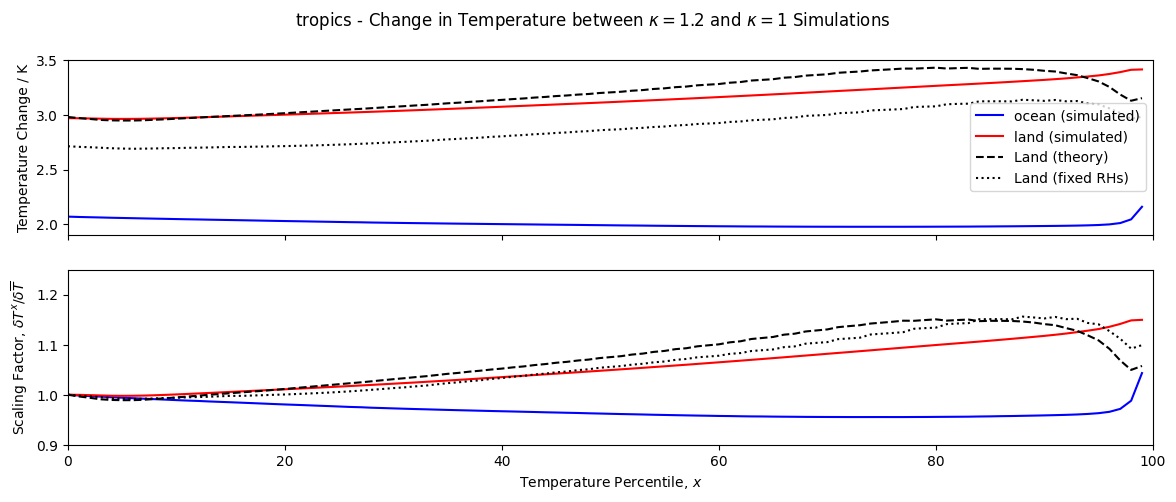

In [13]:
# Plot temperature change vs percentile
temp_diff_land_theory = (gamma_t * delta_temp_o + gamma_r_o * delta_r_o - nabla * delta_r_l_mean) / (1 + e_const * delta_r_l_x)
temp_diff_land_theory_fix_rh = gamma_t * delta_temp_o
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
for surf in ['ocean', 'land']:
    temp_diff_quant = temp_quant[surf][1]-temp_quant[surf][0]
    ax[0].plot(quant_plot, temp_diff_quant, label=f'{surf} (simulated)', color=plt_color[surf])
    ax[1].plot(quant_plot, temp_diff_quant/temp_diff_quant[0], color=plt_color[surf])
ax[0].plot(quant_plot, temp_diff_land_theory, label=f'Land (theory)', linestyle='--', color='k')
ax[0].plot(quant_plot, temp_diff_land_theory_fix_rh, label=f'Land (fixed RHs)', linestyle=':', color='k')
ax[1].plot(quant_plot, temp_diff_land_theory/temp_diff_land_theory[0], label=f'Land (theory)', linestyle='--', color='k')
ax[1].plot(quant_plot, temp_diff_land_theory_fix_rh/temp_diff_land_theory_fix_rh[0],
           label=f'Land (fixed RHs)', linestyle=':', color='k')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].legend()
ax[0].set_xlim(0,100)
# ax[0].set_ylim(4, 8.5)
ax[1].set_ylim(0.9, 1.25)
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Components of land temperature response
This is to replicate Figure 4 in Byrne 2021.

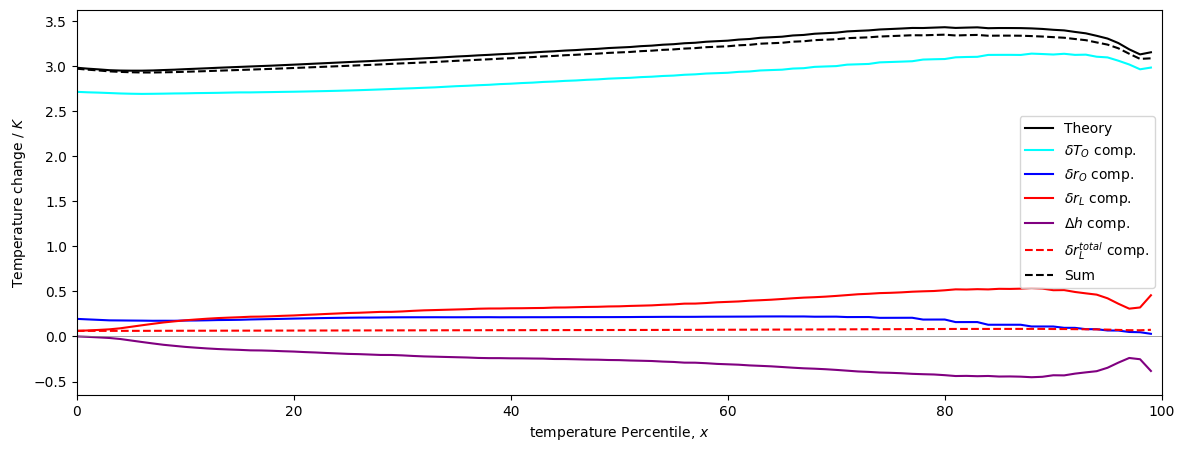

In [14]:
temp_theory_terms = [gamma_t * delta_temp_o,
                     gamma_r_o * delta_r_o,
                     -(e_const/alpha_l)*delta_r_l_x/(1+e_const * delta_r_l_x),
                     e_const/alpha_l*(delta_r_l_x - delta_r_l_mean * q_l_mean_sat/q_l_x_sat)]
temp_theory_terms = np.asarray(temp_theory_terms)
labels = ['$\delta T_O$ comp.', '$\delta r_O$ comp.', '$\delta r_L$ comp.', '$\Delta h$ comp.']
colors = ['cyan', 'blue', 'red', 'purple']
fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(quant_plot, temp_diff_land_theory, label=f'Theory', color='k')
for i, var in enumerate(temp_theory_terms):
    ax.plot(quant_plot, var, label=labels[i], color=colors[i])
ax.plot(quant_plot, np.sum(temp_theory_terms[-2:], axis=0), color='red', linestyle='--', label='$\delta r_L^{total}$ comp.')
ax.plot(quant_plot, np.sum(temp_theory_terms, axis=0), color='k', linestyle='--', label='Sum')
ax.legend()
ax.hlines([0],0,100, color='grey', lw=0.5)
ax.set_xlabel('temperature Percentile, $x$')
ax.set_ylabel('Temperature change / $K$')
ax.set_xlim(0,100);

The below plot shows the $\gamma$ scaling parameters, as in Extended Figure 4.

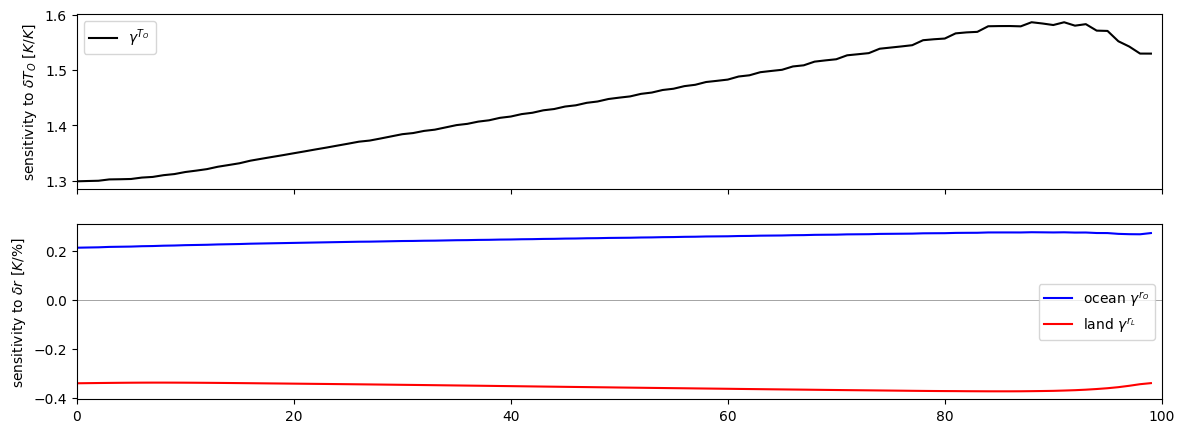

In [36]:
gamma_r_l = -nabla/(100+e_const)
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quant_plot, gamma_t, color='k', label='$\gamma^{T_O}$')
ax[1].plot(quant_plot, gamma_r_o/100, color='b', label='ocean $\gamma^{r_O}$')
ax[1].plot(quant_plot, gamma_r_l, color='r', label='land $\gamma^{r_L}$')
ax[1].hlines([0],0,100, color='grey', lw=0.5)
ax[0].legend()
ax[0].set_ylabel('sensitivity to $\delta T_O$ [$K/K$]')
ax[1].legend()
ax[1].set_ylabel('sensitivity to $\delta r$ [$K/$%]')
ax[0].set_xlim(0,100);

## Supplementary Figure 7 - calculation of $\delta h_O(p_x)$
Check to see if assumption that individual percentiles for temperature and specific humidity can be used to compute change in MSE i.e. want to check if the assumption that $\delta h_O(p_x) \approx c_p \delta T_O(p_x) + L_v \delta q_O(p_x)$ holds.

The plot shows that it holds to within 3% for all percentiles, which while more than the 0.5% in Byrne 2021, is still pretty good.

The taylor expansion used in the $\delta T_L^x$ equation is shown as a solid red line. The other red lines show the taylor expansion including more terms.

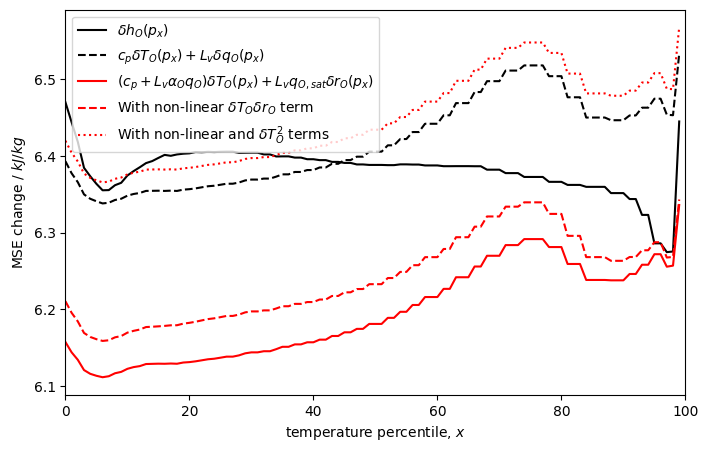

In [147]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x], color='k', label='$\delta h_O(p_x)$')
ax.plot(quant_plot, (c_p * delta_temp_o +
         L_v * (sphum_quant2['ocean'][1][p_x]-sphum_quant2['ocean'][0][p_x]))/1000, color='k',
        label='$c_p \delta T_O(p_x) + L_v \delta q_O(p_x)$', linestyle='--')
term1 = (c_p + L_v * alpha_o * q_o) * delta_temp_o
term2 = L_v * q_o_sat * delta_r_o
term3 = L_v * q_o_sat * alpha_o * delta_r_o * delta_temp_o
term4 = 0.5 * L_v * q_o * alpha_o * (alpha_o - 2/temp_o)*delta_temp_o**2
ax.plot(quant_plot, (term1+term2)/1000, color='r', linestyle='-',
        label='$(c_p+L_v\\alpha_O q_O) \delta T_O(p_x) + L_v q_{O,sat} \delta r_O(p_x)$')
ax.plot(quant_plot, (term1+term2+term3)/1000, color='r', linestyle='--',
        label='With non-linear $\delta T_O \delta r_O$ term')
ax.plot(quant_plot, (term1+term2+term3+term4)/1000, color='r', linestyle=':',
        label='With non-linear and $\delta T_O^2$ terms')
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE change / $kJ/kg$')
ax.legend()
ax.set_xlim(0,100);

If we keep assume we know $\delta h_O(p_x)$ explicitly, the equation for $\delta T_x$ becomes (instead of equation 14 in byrne 2021):
$$\delta T_x = \bigg(\frac{1}{1+\epsilon \delta r_L^x}\bigg) \bigg[ \gamma^h (\delta h_O(p_x) + \Delta h) -
\frac{\epsilon}{\alpha_L}\delta r_L^x \bigg]$$

Where $\gamma^h = \frac{1}{c_p + L_v \alpha_L q_L^x}$.

The $\Delta h$ term can then be derived in the same way (see equation 25) to give the $\Delta h$ comp in terms of $\delta r_L^x$ and $\delta \overline{r_L}$.

But using this equation, we get a large overestimate in $\delta T_x$ for all percentiles as shown below. This is explained from the above plot where the taylor expansion (red solid line) gives a large underestimate in $\delta h_O(p_x)$.

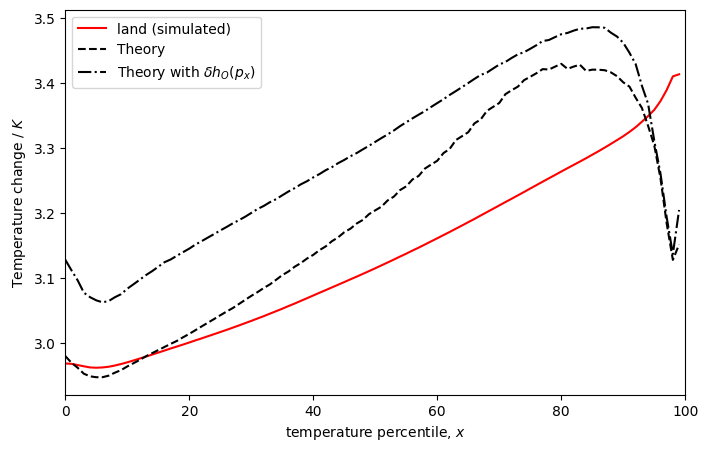

In [146]:
h_o_term = 1000*(mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x]) / (c_p + L_v * alpha_l * q_l_x)
temp_diff_land_theory2 = (h_o_term + temp_theory_terms[-1]) / (1+e_const * delta_r_l_x) + temp_theory_terms[-2]
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, temp_quant['land'][1]-temp_quant['land'][0], color=plt_color['land'], label='land (simulated)')
ax.plot(quant_plot, temp_diff_land_theory, color='k', linestyle='--', label='Theory')
ax.plot(quant_plot, temp_diff_land_theory2, color='k', linestyle='-.', label='Theory with $\delta h_O(p_x)$')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('Temperature change / $K$')
ax.set_xlim(0,100);

Because the taylor expansion above does not seem to match the MSE change over ocean, below we also examine the taylor expansion over land.

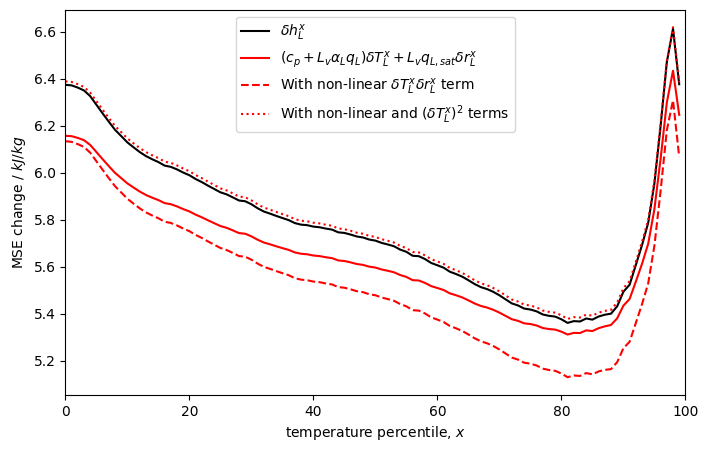

In [139]:
term1 = (c_p + L_v * alpha_l * q_l_x) * (temp_quant['land'][1]-temp_quant['land'][0])
term2 = L_v * q_l_x_sat * delta_r_l_x
term3 = L_v * q_l_x_sat * alpha_l * delta_r_l_x * (temp_quant['land'][1]-temp_quant['land'][0])
term4 = 0.5 * L_v * q_l_x * alpha_l * (alpha_l - 2/temp_quant['land'][0])*(temp_quant['land'][1]-temp_quant['land'][0])**2

fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_quant['land'][1]-mse_quant['land'][0], color='k', label='$\delta h^x_L$')
ax.plot(quant_plot, (term1 + term2)/1000, color='r',
        label='$(c_p+L_v\\alpha_L q_L) \delta T^x_L + L_v q_{L,sat} \delta r^x_L$')
ax.plot(quant_plot, (term1 + term2 + term3)/1000, color='r', linestyle='--',
        label='With non-linear $\delta T^x_L \delta r^x_L$ term')
ax.plot(quant_plot, (term1 + term2 + term3 + term4)/1000, color='r', linestyle=':',
        label='With non-linear and $(\delta T^x_L)^2$ terms')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE change / $kJ/kg$')
ax.set_xlim(0,100);

### Calculation of $\delta q_O(p_x)$ and $\delta q_L^x$
The problem above only arises from the taylor expansion of the change in specific humidity, $\delta q$, terms. So here we do the same analysis but just for this.

It seems that it is quite important to include the $\delta T_O^2$ terms.

In [137]:
def clausius_clapeyron_factor2(temp):
    # Rather than saying d_sphum_sat_d_temp = alpha \times sphum_sat,
    # here I explicitly compute alpha from the formula for saturation_vapor_pressure using in isca_tools
    lambda_const = 4302.645 / (temp - 29.65)**2
    return lambda_const * p_surface / epsilon * sphum_sat(temp, p_surface) / saturation_vapor_pressure(temp)

alpha_o_2 = clausius_clapeyron_factor2(temp_o)
alpha_l_2 = clausius_clapeyron_factor2(temp_quant['land'][0])

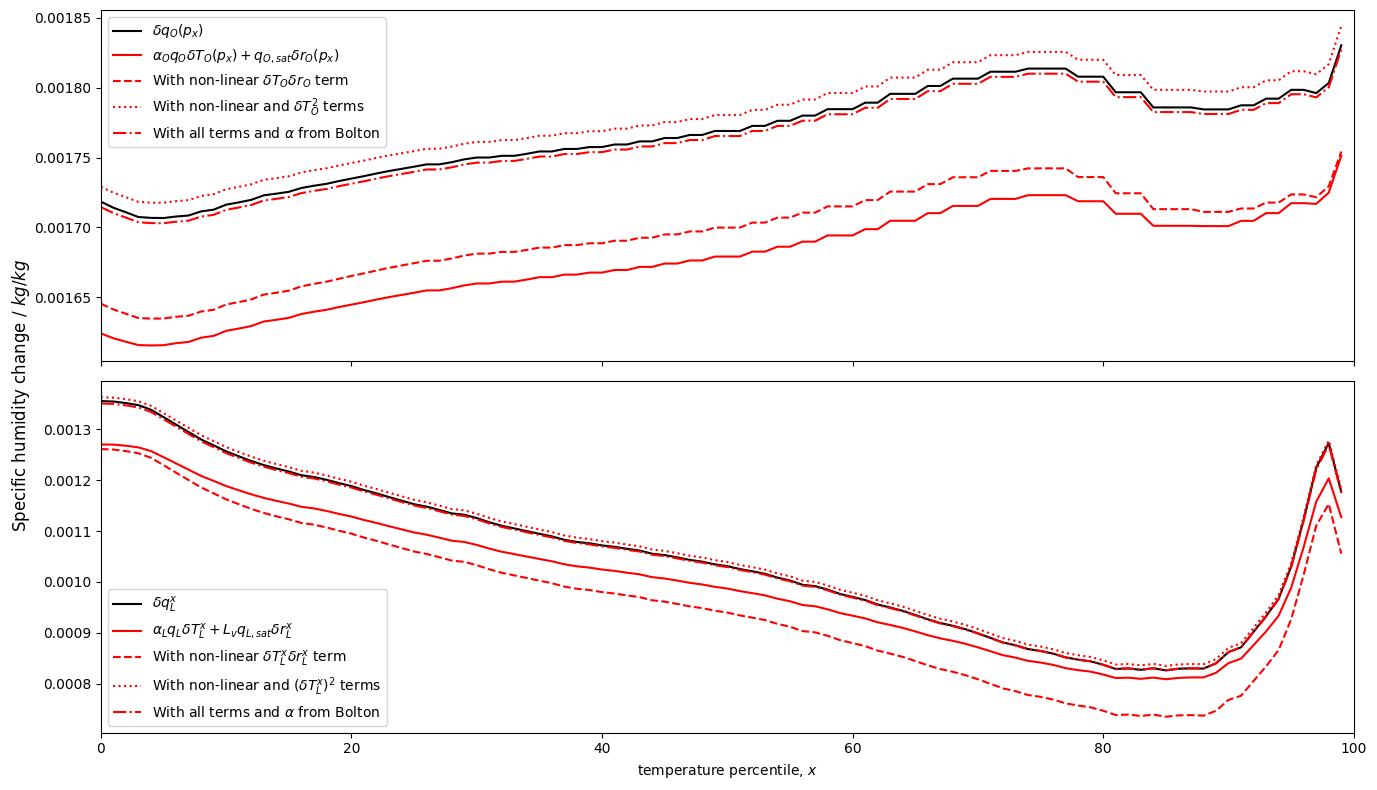

In [145]:
fig, ax = plt.subplots(2,1, figsize=(14, 8), sharex=True)
term1 = alpha_o * q_o * delta_temp_o
term1_alpha2 = alpha_o_2 * q_o * delta_temp_o
term2 = q_o_sat * delta_r_o
term3 = q_o_sat * alpha_o * delta_r_o * delta_temp_o
term3_alpha2 = q_o_sat * alpha_o_2 * delta_r_o * delta_temp_o
term4 = 0.5 * q_o * alpha_o * (alpha_o - 2/temp_o)*delta_temp_o**2
term4_alpha2 = 0.5 * q_o * alpha_o_2 * (alpha_o_2 - 2/temp_o)*delta_temp_o**2
ax[0].plot(quant_plot, sphum_quant2['ocean'][1][p_x]-sphum_quant2['ocean'][0][p_x], color='k', label='$\delta q_O(p_x)$')
ax[0].plot(quant_plot, (term1+term2), color='r', linestyle='-',
        label='$\\alpha_O q_O \delta T_O(p_x) + q_{O,sat} \delta r_O(p_x)$')
ax[0].plot(quant_plot, (term1+term2+term3), color='r', linestyle='--',
        label='With non-linear $\delta T_O \delta r_O$ term')
ax[0].plot(quant_plot, (term1+term2+term3+term4), color='r', linestyle=':',
        label='With non-linear and $\delta T_O^2$ terms')
ax[0].plot(quant_plot, (term1_alpha2+term2+term3_alpha2+term4_alpha2), color='r', linestyle='-.',
        label='With all terms and $\\alpha$ from Bolton')
fig.supylabel('Specific humidity change / $kg/kg$')
ax[0].legend()

term1 = alpha_l * q_l_x * (temp_quant['land'][1]-temp_quant['land'][0])
term1_alpha2 = alpha_l_2 * q_l_x * (temp_quant['land'][1]-temp_quant['land'][0])
term2 = q_l_x_sat * delta_r_l_x
term3 = q_l_x_sat * alpha_l * delta_r_l_x * (temp_quant['land'][1]-temp_quant['land'][0])
term3_alpha2 = q_l_x_sat * alpha_l_2 * delta_r_l_x * (temp_quant['land'][1]-temp_quant['land'][0])
term4 = 0.5 * q_l_x * alpha_l * (alpha_l - 2/temp_quant['land'][0])*(temp_quant['land'][1]-temp_quant['land'][0])**2
term4_alpha2 = 0.5 * q_l_x * alpha_l_2 * (alpha_l_2 - 2/temp_quant['land'][0])*(temp_quant['land'][1]-temp_quant['land'][0])**2
ax[1].plot(quant_plot, sphum_quant['land'][1]-sphum_quant['land'][0], color='k', label='$\delta q^x_L$')
ax[1].plot(quant_plot, (term1 + term2), color='r',
        label='$\\alpha_L q_L \delta T^x_L + L_v q_{L,sat} \delta r^x_L$')
ax[1].plot(quant_plot, (term1 + term2 + term3), color='r', linestyle='--',
        label='With non-linear $\delta T^x_L \delta r^x_L$ term')
ax[1].plot(quant_plot, (term1 + term2 + term3 + term4), color='r', linestyle=':',
        label='With non-linear and $(\delta T^x_L)^2$ terms')
ax[1].plot(quant_plot, (term1_alpha2+term2+term3_alpha2+term4_alpha2), color='r', linestyle='-.',
        label='With all terms and $\\alpha$ from Bolton')
ax[1].legend()
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].set_xlim(0,100)
plt.tight_layout();

The difference between the red dotted and red dashed-dotted line is due to using an inappropriate $\alpha$ value. If I compute $\alpha$ explicitly from the [equation for saturation vapour pressure](http://127.0.0.1:8000/code/utils/moist_physics/#isca_tools.utils.moist_physics.saturation_vapor_pressure) used in the Byrne 2021 paper, I get a lower value of $\alpha$ (as shown below) which results in a better fit above.

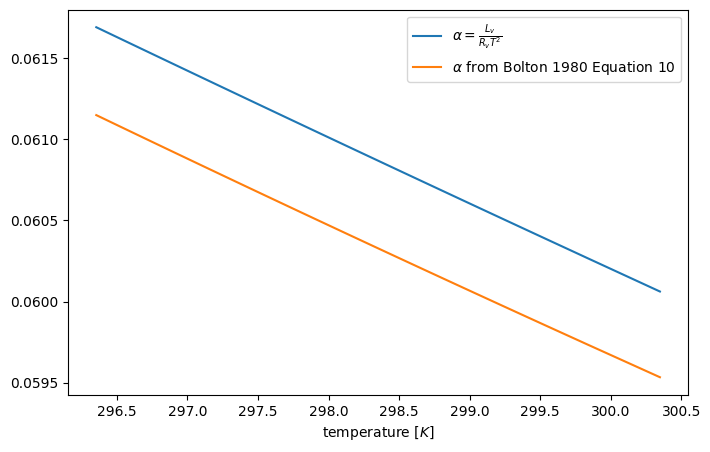

In [136]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(temp_o, clausius_clapeyron_factor(temp_o), label='$\\alpha = \\frac{L_v}{R_v T^2}$')
ax.plot(temp_o, clausius_clapeyron_factor2(temp_o), label='$\\alpha$ from Bolton 1980 Equation 10')
ax.set_xlabel('temperature [$K$]')
ax.legend();

## Theory including $\delta T_O^2$ and $(\delta T_L^x)^2$ terms
All the above work suggests that it is important to use the correct $\alpha$ value and go up to the $\delta T^2$ terms in the taylor expansion. The work below includes these adjustments to the theory.